# Configurações e Importações

In [1]:
%env TF_CPP_MIN_LOG_LEVEL=3

env: TF_CPP_MIN_LOG_LEVEL=3


In [2]:
import ta
import sklearn
import pandas as pd
import numpy as np
import tensorflow
import yfinance as yf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

E0000 00:00:1730205443.847833   23505 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730205443.853060   23505 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Exploração dos Dados Direto da Fonte

In [3]:
def extrai_dados(ticker):
    dados = yf.download(ticker, start= '2000-01-01', end='2023-12-31')
    dados.columns = ['open', 'high', 'low', 'close', 'adj close', 'volume']
    dados.index.name = 'date'
    return dados

In [4]:
df = extrai_dados('MSFT')

[*********************100%***********************]  1 of 1 completed


In [5]:
df.shape

(6037, 6)

In [6]:
df.head()

,open,high,low,close,adj close,volume
date,,,,,,
2000-01-03 00:00:00+00:00,35.935879,58.28125,59.3125,56.00000,58.68750,53228400
2000-01-04 00:00:00+00:00,34.721958,56.31250,58.5625,56.12500,56.78125,54119000
2000-01-05 00:00:00+00:00,35.088036,56.90625,58.1875,54.68750,55.56250,64059600
2000-01-06 00:00:00+00:00,33.912663,55.00000,56.9375,54.18750,56.09375,54976600
2000-01-07 00:00:00+00:00,34.355843,55.71875,56.1250,53.65625,54.31250,62013600


In [7]:
df.tail()

,open,high,low,close,adj close,volume
date,,,,,,
2023-12-22 00:00:00+00:00,372.543915,374.579987,375.179993,372.709991,373.679993,17091100
2023-12-26 00:00:00+00:00,372.623505,374.660004,376.940002,373.500000,375.000000,12673100
2023-12-27 00:00:00+00:00,372.036713,374.070007,375.059998,372.809998,373.690002,14905400
2023-12-28 00:00:00+00:00,373.240112,375.279999,376.459991,374.160004,375.369995,14327000
2023-12-29 00:00:00+00:00,373.995972,376.040009,377.160004,373.480011,376.000000,18723000


# Engenharia de Atributos de Dados Financeiros

In [8]:
def func_engenharia_atributos(df):
    df_copy = df.copy()
    df_copy['retorno'] = df_copy['close'].pct_change(1)
    df_copy['op'] = df_copy['open'].shift(1)
    df_copy['hi'] = df_copy['high'].shift(1)
    df_copy['lo'] = df_copy['low'].shift(1)
    df_copy['clo'] = df_copy['close'].shift(1)
    df_copy['vol'] = df_copy['volume'].shift(1)
    df_copy['SMA 15'] = df_copy[['close']].rolling(15).mean().shift(1)
    df_copy['SMA 60'] = df_copy[['close']].rolling(60).mean().shift(1)
    df_copy['MSD 15'] = df_copy['retorno'].rolling(15).std().shift(1)
    df_copy['MSD 60'] = df_copy['retorno'].rolling(60).std().shift(1)

    vwap = ta.volume.VolumeWeightedAveragePrice(high= df['high'],
                                                low= df['low'],
                                                close= df['close'],
                                                volume= df['volume'],
                                                window= 5)

    df_copy['VWAP'] = vwap.vwap.shift(1)

    RSI = ta.momentum.RSIIndicator(df_copy['close'], window= 5, fillna= False)
    df_copy['RSI'] = RSI.rsi().shift(1)

    return df_copy.dropna()

In [9]:
df = func_engenharia_atributos(df)

In [10]:
df

,open,high,low,close,adj close,volume,retorno,op,hi,lo,clo,vol,SMA 15,SMA 60,MSD 15,MSD 60,VWAP,RSI
date,,,,,,,,,,,,,,,,,,
2000-03-30 00:00:00+00:00,31.870205,51.687500,54.312500,51.250000,53.093750,64178400,-0.024970,33.045578,53.593750,54.468750,52.562500,64363800.0,49.677083,49.762240,0.031745,0.026760,54.201657,62.325986
2000-03-31 00:00:00+00:00,32.756546,53.125000,54.125000,52.062500,53.000000,64281400,0.015854,31.870205,51.687500,54.312500,51.250000,64178400.0,49.927083,49.680990,0.031487,0.026939,53.585763,51.008746
2000-04-03 00:00:00+00:00,28.016481,45.437500,48.250000,45.000000,47.218750,260118200,-0.135654,32.756546,53.125000,54.125000,52.062500,64281400.0,50.081250,49.637240,0.029484,0.026833,52.790422,57.044411
2000-04-04 00:00:00+00:00,27.303547,44.281250,46.000000,42.468750,45.781250,181244400,-0.056250,28.016481,45.437500,48.250000,45.000000,260118200.0,49.831250,49.484115,0.046347,0.031999,49.611815,24.392520
2000-04-05 00:00:00+00:00,26.629154,43.187500,44.250000,42.937500,44.125000,82887600,0.011038,27.303547,44.281250,46.000000,42.468750,181244400.0,49.491667,49.297656,0.048035,0.032731,47.728704,19.414031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22 00:00:00+00:00,372.543915,374.579987,375.179993,372.709991,373.679993,17091100,0.007215,371.509613,373.540009,374.410004,370.040009,17708000.0,367.949333,349.437000,0.009860,0.010621,371.030030,56.957233
2023-12-26 00:00:00+00:00,372.623505,374.660004,376.940002,373.500000,375.000000,12673100,0.002120,372.543915,374.579987,375.179993,372.709991,17091100.0,368.042666,350.491332,0.009643,0.010622,372.476155,68.406513
2023-12-27 00:00:00+00:00,372.036713,374.070007,375.059998,372.809998,373.690002,14905400,-0.001847,372.623505,374.660004,376.940002,373.500000,12673100.0,368.749333,351.466666,0.007259,0.010446,373.058044,71.236313


# Pré-Processamento dos Dados

In [11]:
split = int(0.85 * len(df))
split_val = int(0.95 * len(df))

In [12]:
df.columns

Index(['open', 'high', 'low', 'close', 'adj close', 'volume', 'retorno', 'op',
       'hi', 'lo', 'clo', 'vol', 'SMA 15', 'SMA 60', 'MSD 15', 'MSD 60',
       'VWAP', 'RSI'],
      dtype='object')

In [13]:
x_train = df[['VWAP','RSI','SMA 15','SMA 60','MSD 15','MSD 60','op','hi','lo','clo','vol']].iloc[:split,:]
y_train = df[['retorno']].iloc[:split,:]

In [14]:
x_val = df[['VWAP','RSI','SMA 15','SMA 60','MSD 15','MSD 60','op','hi','lo','clo','vol']].iloc[split:split_val,:]
y_val = df[['retorno']].iloc[split:split_val,:]

In [15]:
x_test = df[['VWAP','RSI','SMA 15','SMA 60','MSD 15','MSD 60','op','hi','lo','clo','vol']].iloc[split_val:,:]
y_test = df[['retorno']].iloc[split_val:,:]

## Padronização

In [16]:
sc = StandardScaler()

In [17]:
x_train_sc = sc.fit_transform(x_train)

In [18]:
x_val_sc = sc.transform(x_val)

In [19]:
x_test_sc = sc.transform(x_test)

## Ajuste no Formato dos Dados

In [20]:
x_train

,VWAP,RSI,SMA 15,SMA 60,MSD 15,MSD 60,op,hi,lo,clo,vol
date,,,,,,,,,,,
2000-03-30 00:00:00+00:00,54.201657,62.325986,49.677083,49.762240,0.031745,0.026760,33.045578,53.593750,54.468750,52.562500,64363800.0
2000-03-31 00:00:00+00:00,53.585763,51.008746,49.927083,49.680990,0.031487,0.026939,31.870205,51.687500,54.312500,51.250000,64178400.0
2000-04-03 00:00:00+00:00,52.790422,57.044411,50.081250,49.637240,0.029484,0.026833,32.756546,53.125000,54.125000,52.062500,64281400.0
2000-04-04 00:00:00+00:00,49.611815,24.392520,49.831250,49.484115,0.046347,0.031999,28.016481,45.437500,48.250000,45.000000,260118200.0
2000-04-05 00:00:00+00:00,47.728704,19.414031,49.491667,49.297656,0.048035,0.032731,27.303547,44.281250,46.000000,42.468750,181244400.0
...,...,...,...,...,...,...,...,...,...,...,...
2020-06-02 00:00:00+00:00,182.002271,55.482827,180.769335,164.530001,0.016584,0.026032,176.192230,182.830002,183.000000,181.460007,22622400.0
2020-06-03 00:00:00+00:00,182.096349,54.643215,180.669335,164.952501,0.016572,0.024801,178.196732,184.910004,185.000000,181.350006,30794600.0
2020-06-04 00:00:00+00:00,183.090688,67.215358,180.754668,165.512168,0.016870,0.024229,178.630371,185.360001,185.940002,183.580002,27311000.0


In [21]:
x_train_sc

array([[ 0.28234306,  0.43492185,  0.16713384, ...,  0.2709324 ,
         0.24671724,  0.30086637],
       [ 0.26384156, -0.08941668,  0.17478823, ...,  0.26630361,
         0.20705   ,  0.29497362],
       [ 0.23994947,  0.19022143,  0.17950843, ...,  0.26074905,
         0.23160591,  0.29824737],
       ...,
       [ 4.15417528,  0.66145112,  4.18040848, ...,  4.1656744 ,
         4.2064143 , -0.87682002],
       [ 4.16503397,  0.14485868,  4.19216564, ...,  4.16271179,
         4.16772933, -0.83070778],
       [ 4.18949152,  0.02829954,  4.20508625, ...,  4.21870168,
         4.1589645 , -0.47689459]])

In [22]:
def ajusta_formato_dados(X_s, y_s, lag):

    if len(X_s) != len(y_s):
        print('Warnings')

    X_train = []

    for variable in range(0, X_s.shape[1]):
        X = []

        for i in range(lag, X_s.shape[0]):
            X.append(X_s[i-lag:i, variable])

        X_train.append(X)

    X_train = np.array(X_train)
    X_train = np.swapaxes(np.swapaxes(X_train, 0, 1), 1, 2)

    y_train = []

    for i in range(lag, y_s.shape[0]):
        y_train.append(y_s[i,:].reshape(-1, 1).transpose())

    y_train = np.concatenate(y_train, axis = 0)

    return X_train, y_train

In [23]:
lag = 15

In [24]:
x_train_final, y_train_final = ajusta_formato_dados(x_train_sc, y_train.values, lag)

In [25]:
x_valid_final, y_valid_final = ajusta_formato_dados(x_val_sc, y_val.values, lag)

In [26]:
x_test_final, y_test_final = ajusta_formato_dados(x_test_sc, y_test.values, lag)

In [27]:
print(f'Shape dos dados de treino : {x_train_final.shape}')
print(f'Shape dos dados de validação : {x_valid_final.shape}')
print(f'Shape dos dados de teste : {x_test_final.shape}')

Shape dos dados de treino : (5064, 15, 11)
Shape dos dados de validação : (583, 15, 11)
Shape dos dados de teste : (284, 15, 11)


In [28]:
x_train_final

array([[[ 0.28234306,  0.43492185,  0.16713384, ...,  0.2709324 ,
          0.24671724,  0.30086637],
        [ 0.26384156, -0.08941668,  0.17478823, ...,  0.26630361,
          0.20705   ,  0.29497362],
        [ 0.23994947,  0.19022143,  0.17950843, ...,  0.26074905,
          0.23160591,  0.29824737],
        ...,
        [-0.1410498 , -1.96342272,  0.02356623, ..., -0.16510006,
         -0.23495637,  3.06143437],
        [-0.16738678, -1.97322588, -0.00800812, ..., -0.21694256,
         -0.2387342 ,  2.06196725],
        [-0.17579493, -1.04442264, -0.03505362, ..., -0.12899546,
         -0.19528913,  1.17272707]],

       [[ 0.26384156, -0.08941668,  0.17478823, ...,  0.26630361,
          0.20705   ,  0.29497362],
        [ 0.23994947,  0.19022143,  0.17950843, ...,  0.26074905,
          0.23160591,  0.29824737],
        [ 0.144464  , -1.3225718 ,  0.17185404, ...,  0.08670637,
          0.01815839,  6.52272526],
        ...,
        [-0.16738678, -1.97322588, -0.00800812, ..., -

# Construção do Modelo Temporal Fusion Transformer

In [29]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout = 0):
    
    x = layers.LayerNormalization(epsilon = 1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim = head_size, num_heads = num_heads, dropout = dropout)(x, x, x)
    x = layers.Dropout(dropout)(x)
    
    res = x + inputs

    x = layers.LayerNormalization(epsilon = 1e-6)(res)
    x = layers.Conv1D(filters = ff_dim, kernel_size = 1, activation = "relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters = inputs.shape[-1], kernel_size = 1)(x)

    return x + res

In [30]:
def cria_modelo(input_shape,
                head_size,
                num_heads,
                ff_dim,
                num_transformer_blocks,
                mlp_units,
                dropout = 0,
                mlp_dropout = 0):
    
    inputs = keras.Input(shape = input_shape)
    x = inputs
    x = layers.LSTM(10, return_sequences= True)(x)

    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GRU(100, return_sequences= False)(x)
    x = layers.Dropout(mlp_dropout)(x)
    x = layers.Dense(mlp_units, activation= 'relu')(x)
    outputs = layers.Dense(1)(x)

    return keras.Model(inputs, outputs)

In [31]:
input_shape = x_train_final.shape[1:]

In [32]:
model = cria_modelo(input_shape,
                    head_size= 16,
                    num_heads= 1,
                    ff_dim= 4,
                    num_transformer_blocks= 1,
                    mlp_units= 125,
                    dropout= 0.1,
                    mlp_dropout= 0.25)

W0000 00:00:1730205446.592805   23505 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [33]:
model.compile(loss= 'mean_squared_error', optimizer = keras.optimizers.Adam())

In [34]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 15, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 15, 10)    │        880 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 15, 10)    │         20 │ lstm[0][0]        │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 15, 10)    │        698 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 15, 10)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 15, 10)    │          0 │ dropout_1[0][0],  │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 10)    │         20 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 15, 4)     │         44 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 15, 4)     │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 15, 10)    │         50 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 15, 10)    │          0 │ conv1d_1[0][0],   │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 100)       │     33,600 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 100)       │          0 │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 125)       │     12,625 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        126 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 48,063 (187.75 KB)

 Trainable params: 48,063 (187.75 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
callbacks = [keras.callbacks.EarlyStopping(patience= 5, restore_best_weights= True)]

# Treino e Avaliação do Modelo

%%time
model.fit(x_train_final,
          y_train_final,
          validation_data= (x_valid_final, y_valid_final),
          epochs= 20,
          batch_size= 64,
          callbacks= callbacks)

<Axes: >

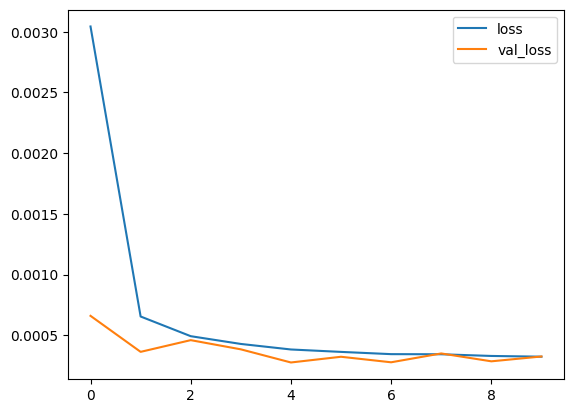

In [37]:
pd.DataFrame(model.history.history).plot()

In [38]:
pred = model.predict(x_test_final)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


In [39]:
score = np.sqrt(metrics.mean_squared_error(pred, y_test_final))

In [40]:
print(f'Score (RMSE) : {score}')

Score (RMSE) : 0.014920072605684138


# Previsões e Cálculo do Retorno

In [41]:
y_pred_train = np.concatenate((np.zeros([lag, 1]), model.predict(x_train_final)), axis = 0)

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [43]:
y_pred_valid = np.concatenate((np.zeros([lag, 1]), model.predict(x_valid_final)), axis = 0)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [44]:
y_pred_test = np.concatenate((np.zeros([lag, 1]), model.predict(x_test_final)), axis = 0)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [45]:
df['prediction'] = np.concatenate((y_pred_train, y_pred_valid, y_pred_test), axis = 0)

In [46]:
df.tail()

,open,high,low,close,adj close,volume,retorno,op,hi,lo,clo,vol,SMA 15,SMA 60,MSD 15,MSD 60,VWAP,RSI,prediction
date,,,,,,,,,,,,,,,,,,,
2023-12-22 00:00:00+00:00,372.543915,374.579987,375.179993,372.709991,373.679993,17091100,0.007215,371.509613,373.540009,374.410004,370.040009,17708000.0,367.949333,349.437000,0.009860,0.010621,371.030030,56.957233,0.006933
2023-12-26 00:00:00+00:00,372.623505,374.660004,376.940002,373.500000,375.000000,12673100,0.002120,372.543915,374.579987,375.179993,372.709991,17091100.0,368.042666,350.491332,0.009643,0.010622,372.476155,68.406513,0.007692
2023-12-27 00:00:00+00:00,372.036713,374.070007,375.059998,372.809998,373.690002,14905400,-0.001847,372.623505,374.660004,376.940002,373.500000,12673100.0,368.749333,351.466666,0.007259,0.010446,373.058044,71.236313,0.007685
2023-12-28 00:00:00+00:00,373.240112,375.279999,376.459991,374.160004,375.369995,14327000,0.003621,372.036713,374.070007,375.059998,372.809998,14905400.0,369.228666,352.427166,0.007149,0.010460,373.430889,64.890753,0.007010
2023-12-29 00:00:00+00:00,373.995972,376.040009,377.160004,373.480011,376.000000,18723000,-0.001817,373.240112,375.279999,376.459991,374.160004,14327000.0,369.637333,353.476333,0.007033,0.010261,374.135981,71.171196,0.007436


In [47]:
df['estrategia'] = df['retorno'] * np.sign(df['prediction'].shift(1))

In [48]:
df.tail()

,open,high,low,close,adj close,volume,retorno,op,hi,lo,clo,vol,SMA 15,SMA 60,MSD 15,MSD 60,VWAP,RSI,prediction,estrategia
date,,,,,,,,,,,,,,,,,,,,
2023-12-22 00:00:00+00:00,372.543915,374.579987,375.179993,372.709991,373.679993,17091100,0.007215,371.509613,373.540009,374.410004,370.040009,17708000.0,367.949333,349.437000,0.009860,0.010621,371.030030,56.957233,0.006933,0.007215
2023-12-26 00:00:00+00:00,372.623505,374.660004,376.940002,373.500000,375.000000,12673100,0.002120,372.543915,374.579987,375.179993,372.709991,17091100.0,368.042666,350.491332,0.009643,0.010622,372.476155,68.406513,0.007692,0.002120
2023-12-27 00:00:00+00:00,372.036713,374.070007,375.059998,372.809998,373.690002,14905400,-0.001847,372.623505,374.660004,376.940002,373.500000,12673100.0,368.749333,351.466666,0.007259,0.010446,373.058044,71.236313,0.007685,-0.001847
2023-12-28 00:00:00+00:00,373.240112,375.279999,376.459991,374.160004,375.369995,14327000,0.003621,372.036713,374.070007,375.059998,372.809998,14905400.0,369.228666,352.427166,0.007149,0.010460,373.430889,64.890753,0.007010,0.003621
2023-12-29 00:00:00+00:00,373.995972,376.040009,377.160004,373.480011,376.000000,18723000,-0.001817,373.240112,375.279999,376.459991,374.160004,14327000.0,369.637333,353.476333,0.007033,0.010261,374.135981,71.171196,0.007436,-0.001817


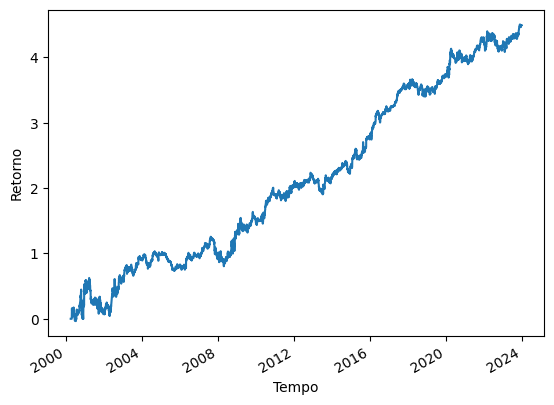

In [49]:
df['estrategia'].iloc[:].cumsum().plot()
plt.xlabel('Tempo')
plt.ylabel('Retorno')
plt.show()